# Import packages needed for mappdf demo

In [4]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from diffpy.pdfgetx import PDFGetter, PDFConfig

# utils for mapPDF
from utils import *

bSeabornStyle()

# Define filepath to informations

In [5]:
# defined example files
meta_data_fp = 'meta/20161115-220716_grid_scan_md.txt'
chi_dir = 'chi/'
background_fp = 'background/PCA_background.txt'

# Load raw I(Q) data

In [6]:
# load lookup table
raw_df =pd.read_csv(meta_data_fp)

# optional; to exclude function
qoi_colmns  = ['diff_x', 'diff_y']
df = raw_df[qoi_colmns].copy()  # the main df to work on

# list of file name
chi_name_list, Q_array, Iq_array = load_chi(chi_dir)
df['chi_file_name'] = pd.Series(chi_name_list)

# load real background
bkg_q, bkg_Iq = np.loadtxt(background_fp).T

INFO: load Q_array.shape = (136, 1476), Iq_array.shape = (136, 1476)


In [7]:
# view the first 5 rows for example
df.head()

,diff_x,diff_y,chi_file_name
0,9.4,25.44,Catalyst_Array_DenseMap_075785_0001.chi
1,9.4,24.44,Catalyst_Array_DenseMap_075785_0002.chi
2,9.4,23.44,Catalyst_Array_DenseMap_075785_0003.chi
3,9.4,22.44,Catalyst_Array_DenseMap_075785_0004.chi
4,9.4,21.44,Catalyst_Array_DenseMap_075785_0005.chi


# Pearson map of I(Q) wrt backgrounds for first screening 

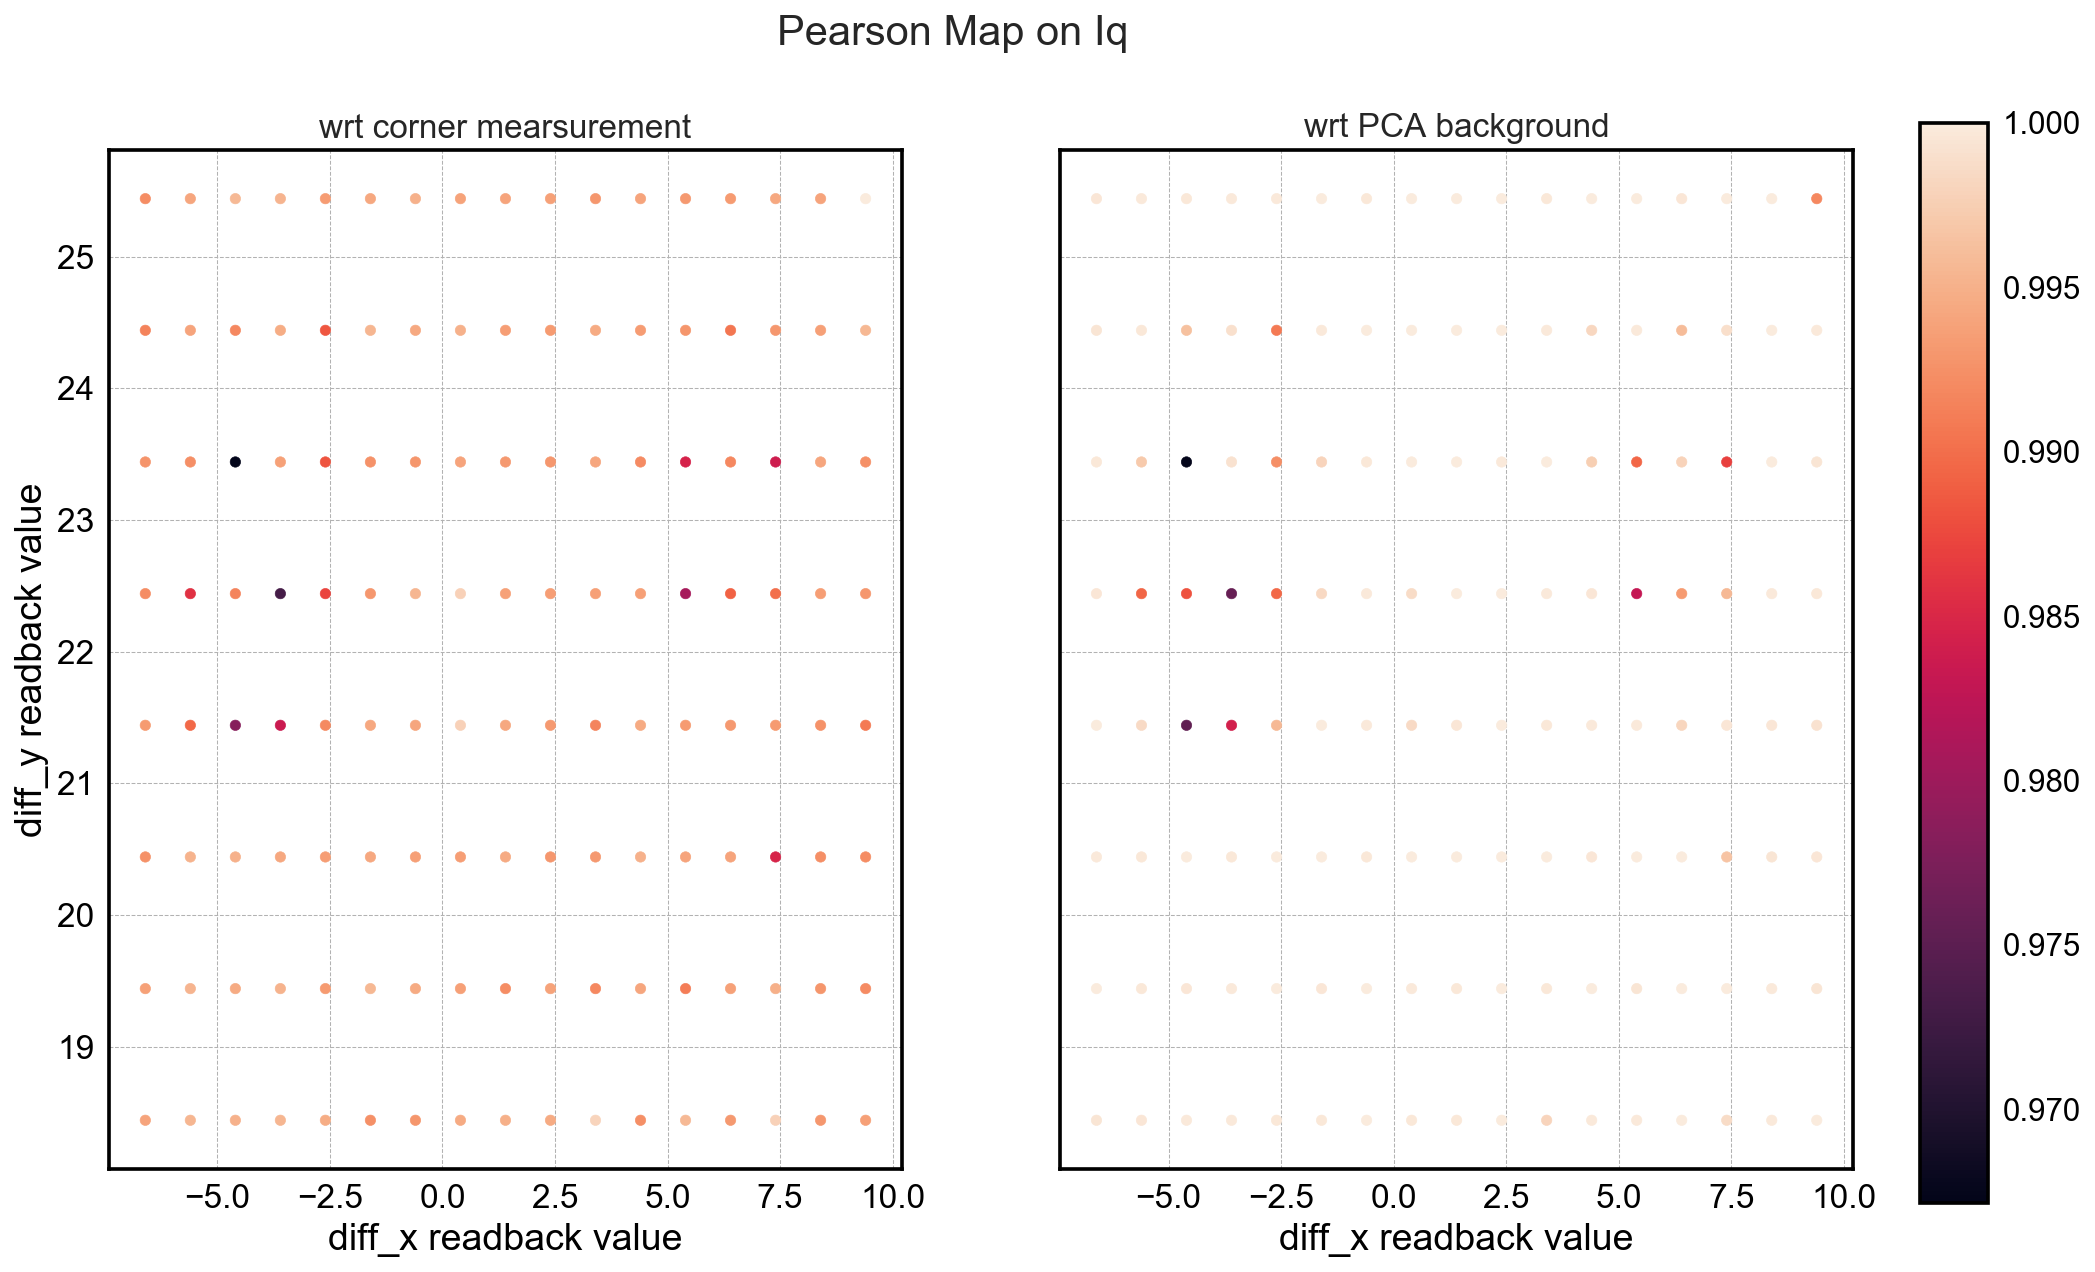

In [8]:
# pearson map
pearson_map1 = np.apply_along_axis(pearsonr, 1, Iq_array, Iq_array[0])
pearson_map2 = np.apply_along_axis(pearsonr, 1, Iq_array, bkg_Iq)

# create scatter plot with pearson map
fig, ax = plt.subplots(1,2, figsize=(15,9), sharey=True)
fig.suptitle('Pearson Map on Iq', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
im = ax[0].scatter(df['diff_x'], df['diff_y'], c=pearson_map1[:,0])
ax[1].scatter(df['diff_x'], df['diff_y'], c=pearson_map2[:,0])
fig.colorbar(im, cax=cax)

ax[0].set_title('wrt corner mearsurement', fontsize=16)
ax[1].set_title('wrt PCA background', fontsize=16)
ax[0].set_ylabel('diff_y readback value')
for el in ax:
    el.set_xlabel('diff_x readback value')
    conf_label_size(el, 18)
    conf_tick_size(el, 16)
plt.set_cmap('inferno')

# Subtracting background to extrac signal

In [9]:
Iq_array_subPCA = Iq_array - bkg_Iq
Iq_array_subCorner = Iq_array - Iq_array[0]

# Process I(Q) to PDF

In [10]:
# define transformation config
base_config = dict(qmaxinst=17, qmin=0.8, qmax=17, dataformat='Qnm',
                   composition=None, rmin=0.0, rmax=100.0, rstep=0.01)

# define composition per row
composition_list = ['CPtCu']*len(df)

# transform Iq
Gr_array_PCA = []
Gr_array_corner = []
pdfgetter = PDFGetter()
for Iq_list, Gr_list in zip([Iq_array_subPCA, Iq_array_subCorner], [Gr_array_PCA, Gr_array_corner]):
    for q, Iq, comp in zip(Q_array, Iq_list, composition_list):
        config = dict(base_config)
        config['composition'] = comp
        # explicitly transform
        r, Gr = pdfgetter(q, Iq, **config)
        Gr_list.append(Gr)
    
Gr_array_PCA = np.asarray(Gr_array_PCA)
Gr_array_corner = np.asarray(Gr_array_corner)

# transform PCA Iq
config = dict(base_config)
config['composition'] = 'C'
r, PCA_bkg_Gr = pdfgetter(bkg_q, bkg_Iq, **config)

# Visualize 95% confidence interval (CI) of transformed Gr_array

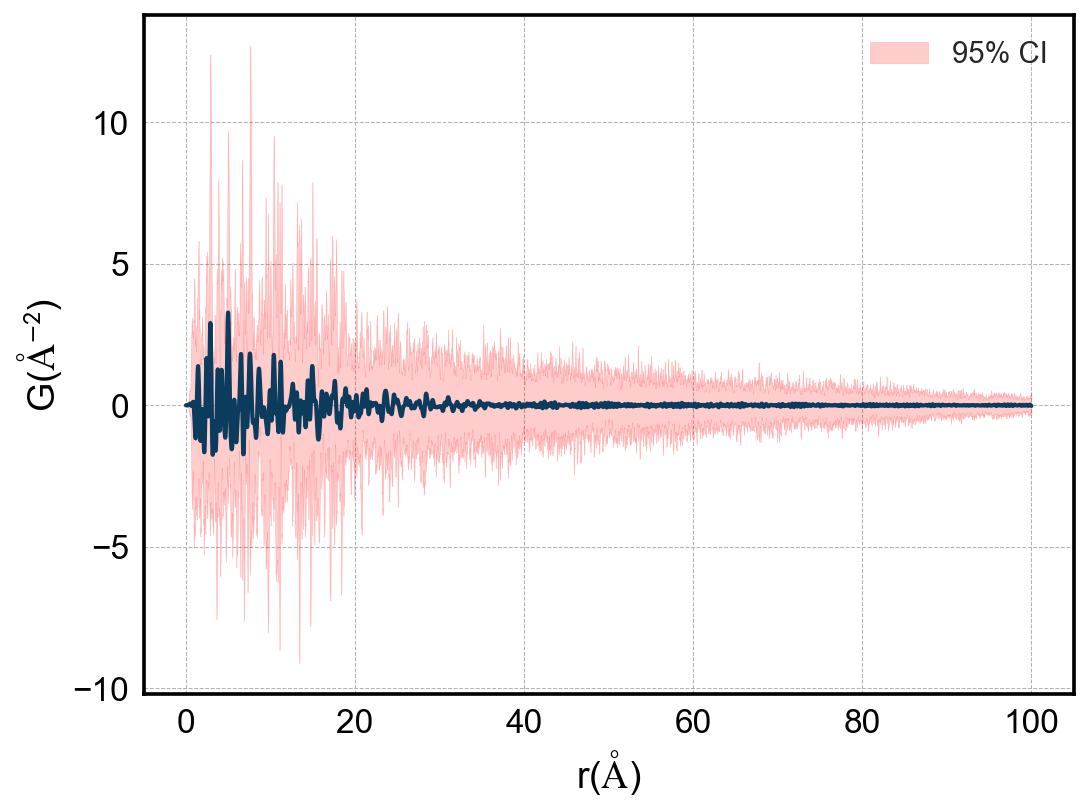

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
low, high = np.percentile(Gr_array_PCA, axis=0, q=[2.5, 97.5])
ax.plot(r, Gr_array_PCA.mean(0))
ax.fill_between(r, low, high, color='r', alpha=0.2, label='95% CI')
ax.legend(fontsize=14)
conf_label_size(ax, 18)
conf_tick_size(ax, 16)
ax.set_xlabel(r'r($\mathrm{\AA}$)')
ax.set_ylabel(r'G($\mathrm{\AA}^{-2}$)')

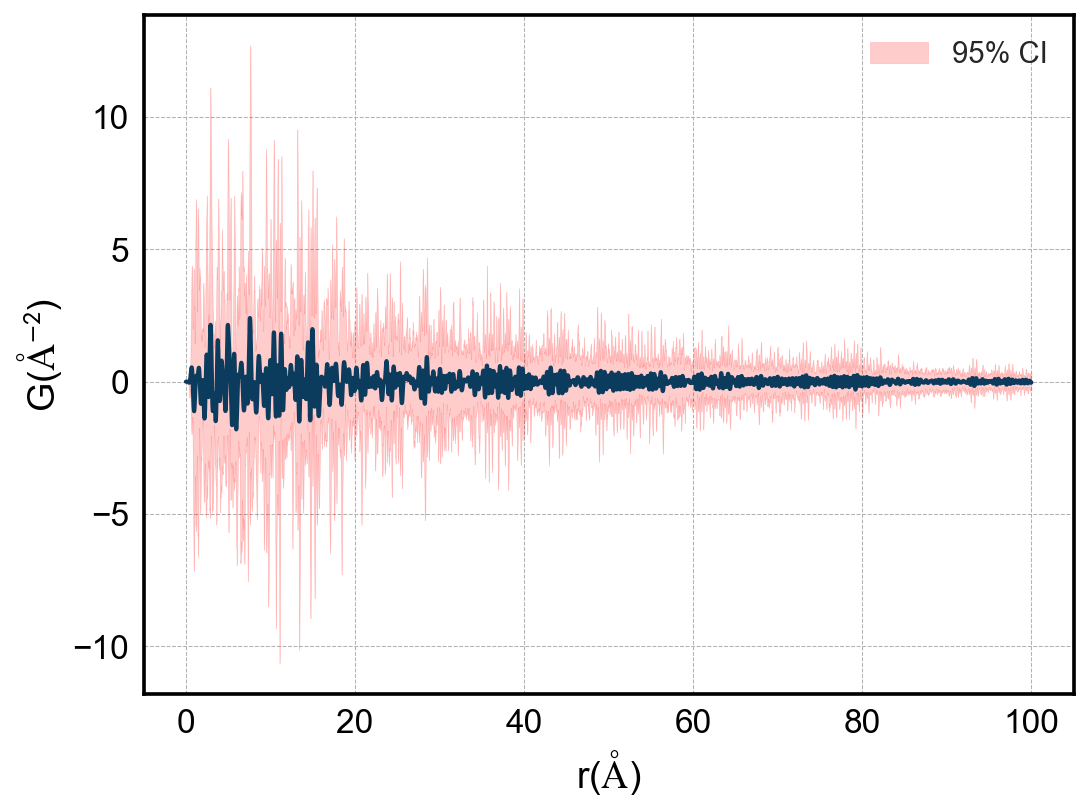

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
low, high = np.percentile(Gr_array_corner, axis=0, q=[2.5, 97.5])
ax.plot(r, Gr_array_corner.mean(0))
ax.fill_between(r, low, high, color='r', alpha=0.2, label='95% CI')
ax.legend(fontsize=14)
conf_label_size(ax, 18)
conf_tick_size(ax, 16)
ax.set_xlabel(r'r($\mathrm{\AA}$)')
ax.set_ylabel(r'G($\mathrm{\AA}^{-2}$)')

# Pearson map of G(r)

/Users/timothyliu/miniconda3/envs/bs_dev/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


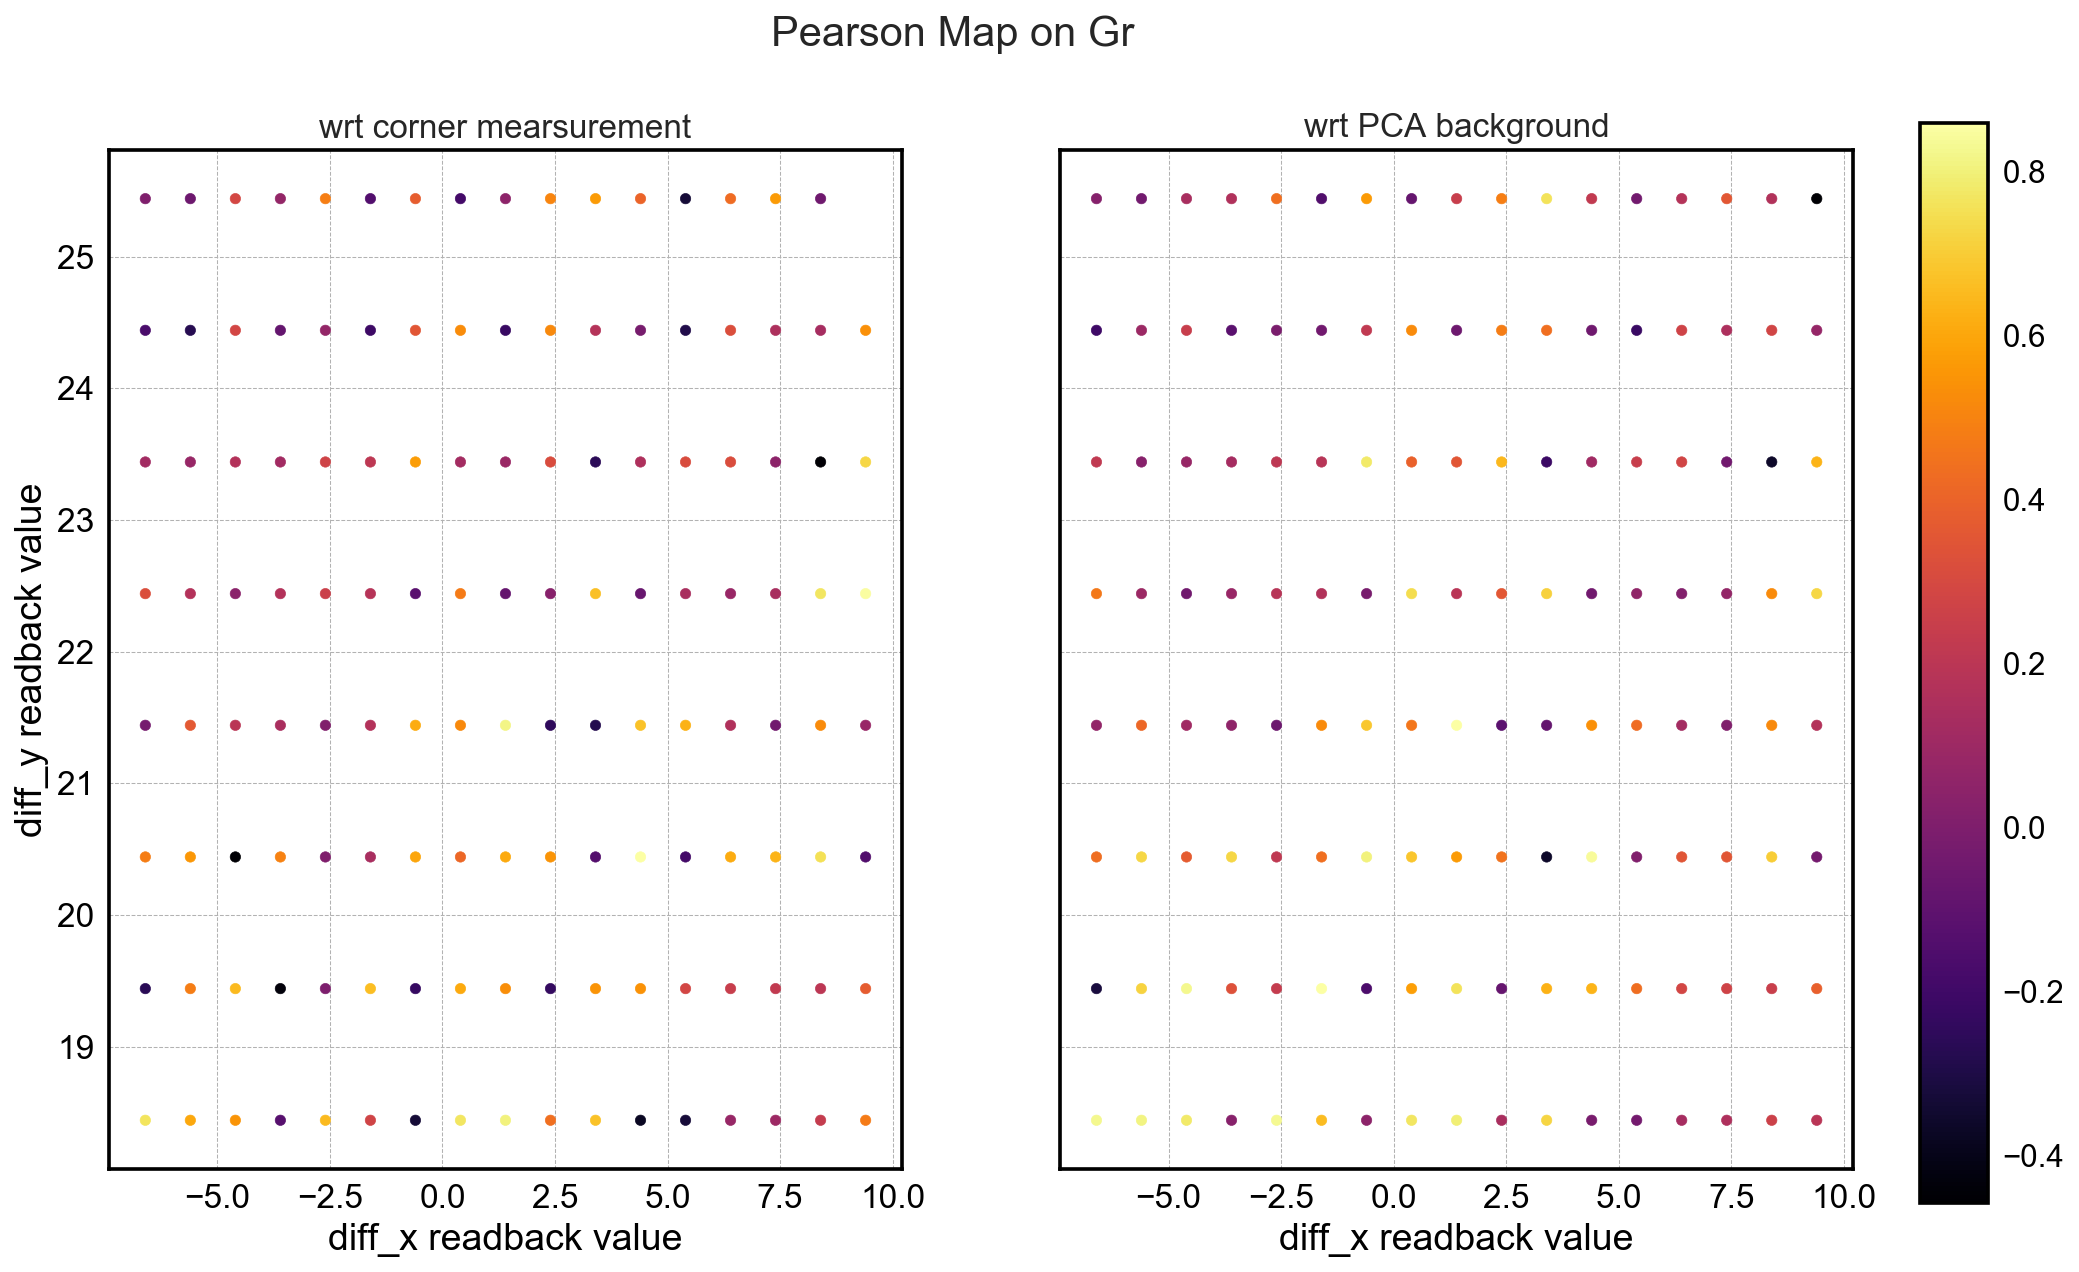

In [14]:
# pearson map
pearson_map1 = np.apply_along_axis(pearsonr, 1, Gr_array_corner, PCA_bkg_Gr)
pearson_map2 = np.apply_along_axis(pearsonr, 1, Gr_array_PCA, PCA_bkg_Gr)

# create scatter plot with pearson map
fig, ax = plt.subplots(1,2, figsize=(15,9), sharey=True)
fig.suptitle('Pearson Map on Gr', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
im = ax[0].scatter(df['diff_x'], df['diff_y'], c=pearson_map1[:,0])
ax[1].scatter(df['diff_x'], df['diff_y'], c=pearson_map2[:,0])
fig.colorbar(im, cax=cax)

ax[0].set_title('wrt corner mearsurement', fontsize=16)
ax[1].set_title('wrt PCA background', fontsize=16)
ax[0].set_ylabel('diff_y readback value')
for el in ax:
    el.set_xlabel('diff_x readback value')
    conf_label_size(el, 18)
    conf_tick_size(el, 16)
plt.set_cmap('inferno')